In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-03-10 12:47:03.973811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 12:47:03.980833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 12:47:03.981442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
import os
import platform
from absl import app
from absl import flags
from absl import logging
#import tensorflow as tf

import dataloader
import hparams_config
import utils
from tf2 import train_lib
from tf2 import util_keras

In [4]:
import matplotlib.pyplot as plt
from visualize.vis_utils import draw_bounding_boxes_on_image_tensors
import numpy as np

In [5]:
model_name = 'efficientdet-d2'
config = hparams_config.get_detection_config(model_name)

config.num_epochs = 300
config.batch_size = 4
#config.batch = 2
config.moving_average_decay = None
config.image_size = (768,768)
config.model_dir = '/host/04 - Plovila Detection/data/01 active - open images data and labels'
config.log_dir = '_logs'
config.val_json_file = None
config.steps_per_execution = 1
config.max_instances_per_image = 200
config.strategy = 'gpus'

use_fake_data = False
debug = False

## TODO: AUTOMATIC NUM SAMPLES CALC
config.steps_per_epoch = 21648//config.batch_size
config.num_classes = 1
validation_steps = 3821//config.batch_size

In [6]:
def get_dataset(is_training, config):
    file_pattern = (
        "_logs/tfrecords/train-*.tfrecord"
        if is_training else "_logs/tfrecords/val-*.tfrecord")
    if not file_pattern:
      raise ValueError('No matching files.')

    return dataloader.InputReader(
        file_pattern,
        is_training=is_training,
        use_fake_data=use_fake_data,
        max_instances_per_image=config.max_instances_per_image,
        debug=debug)(config.as_dict())

In [7]:
train_dataset = get_dataset(True, config)
val_dataset = get_dataset(False, config) 

2022-03-10 12:47:04.657074: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 12:47:04.657920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 12:47:04.658566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 12:47:04.658997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [34]:
from PIL import Image

In [12]:
cls = {1: {'id': 1, 'name': 'Boat'}, 2: {'id': 2, 'name': 'Jet ski'}}

<dtype: 'float32'>


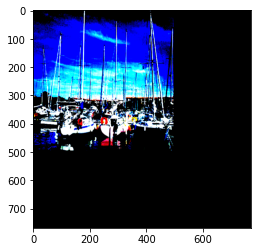

(4, 768, 768, 3) <dtype: 'uint8'>
(4, 200, 7)
(4, 768, 768, 3) (4, 200, 4) (4, 200) (4, 200)
image_0.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0F4BAC0>
image_1.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0DCE220>
image_2.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF11FE5E0>
image_3.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0F4BAC0>
<dtype: 'float32'>


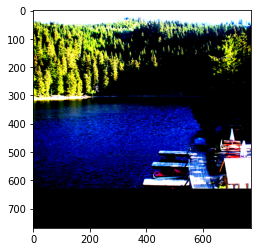

(4, 768, 768, 3) <dtype: 'uint8'>
(4, 200, 7)
(4, 768, 768, 3) (4, 200, 4) (4, 200) (4, 200)
image_0.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF1022460>
image_1.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F2001693850>
image_2.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF102FCA0>
image_3.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F2001661B50>
<dtype: 'float32'>


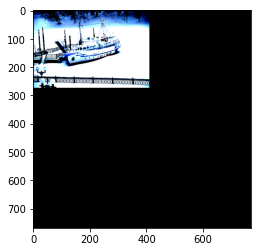

(4, 768, 768, 3) <dtype: 'uint8'>
(4, 200, 7)
(4, 768, 768, 3) (4, 200, 4) (4, 200) (4, 200)
image_0.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0DC3400>
image_1.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF111C8B0>
image_2.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0DE2A30>
image_3.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0FADA90>
<dtype: 'float32'>


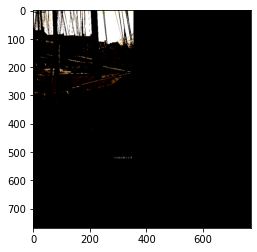

(4, 768, 768, 3) <dtype: 'uint8'>
(4, 200, 7)
(4, 768, 768, 3) (4, 200, 4) (4, 200) (4, 200)
image_0.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0E8AF40>
image_1.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF10684F0>
image_2.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0E519D0>
image_3.png
<PIL.Image.Image image mode=RGB size=768x768 at 0x7F1FF0F3ED60>


In [57]:
for images,labels in train_dataset.take(1):
  for i in range(4):
    print(images.dtype)
    plt.imshow(images[i,...])
    plt.show()
    img_uint8 = tf.cast(images*255, tf.uint8)
    print(img_uint8.shape,img_uint8.dtype)
    print(labels['groundtruth_data'][:].shape)
    boxes = labels['groundtruth_data'][:,:,:4]
    confidence = labels['groundtruth_data'][:,:,5]
    
    classes = labels['groundtruth_data'][:,:,6].numpy()
    print(images.shape,boxes.shape,confidence.shape,classes.shape)
    
    images_with_boxes = draw_bounding_boxes_on_image_tensors(
              img_uint8,
              boxes,
              classes,
              confidence,
              cls,
              min_score_thresh=0.2)
    g = images_with_boxes[2,...]*255
#     for i in range(images_with_boxes.shape[0]):
#       img_name = 'image_' + str(i) + '.png'
#       print(img_name)
#       #output_file = os.path.join(self.get_temp_dir(), img_name)
#       image_pil = Image.fromarray(g.numpy())
#       print(image_pil)
#       #image_pil.save(img_name)